In [74]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [75]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'
tfjs_save_path = 'model/keypoint_classifier/tfjs_model'

# Set number of classes

In [76]:
NUM_CLASSES = 26

# Dataset reading

In [77]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [78]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [80]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [81]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_8 (Dropout)         (None, 42)                0         
                                                                 
 dense_12 (Dense)            (None, 20)                860       
                                                                 
 dropout_9 (Dropout)         (None, 20)                0         
                                                                 
 dense_13 (Dense)            (None, 10)                210       
                                                                 
 dense_14 (Dense)            (None, 26)                286       
                                                                 
Total params: 1,356
Trainable params: 1,356
Non-trainable params: 0
_________________________________________________________________


In [84]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [85]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [86]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
6/8 [=====================>........] - ETA: 0s - loss: 3.3058 - accuracy: 0.0247
Epoch 1: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
8/8 [==============================] - 2s 99ms/step - loss: 3.3051 - accuracy: 0.0263 - val_loss: 3.2524 - val_accuracy: 0.0000e+00
Epoch 2/1000
8/8 [==============================] - ETA: 0s - loss: 3.2757 - accuracy: 0.0231
Epoch 2: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
8/8 [==============================] - 0s 58ms/step - loss: 3.2757 - accuracy: 0.0231 - val_loss: 3.2340 - val_accuracy: 0.0000e+00
Epoch 3/1000
8/8 [==============================] - ETA: 0s - loss: 3.2428 - accuracy: 0.0336
Epoch 3: saving model to model/keypoint_classifier\keypoint_classifier.hdf5
8/8 [==============================] - 0s 47ms/step - loss: 3.2428 - accuracy: 0.0336 - val_loss: 3.2174 - val_accuracy: 0.0660
Epoch 4/1000
6/8 [=====================>........] - ETA: 0s - loss: 3.2358 - accuracy: 0.0560
Epoc

In [87]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

3/3 [==============================] - 0s 10ms/step - loss: 0.6895 - accuracy: 0.8585


In [88]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [89]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 102ms/step
[3.80872400e-03 6.93382346e-04 5.81663062e-06 1.61473959e-04
 1.98616236e-02 3.51777184e-03 3.06106376e-04 5.68949872e-07
 7.26265013e-02 6.01548993e-04 1.85324325e-07 1.85852026e-04
 5.27186133e-03 1.12593295e-02 4.32809065e-05 3.79746348e-06
 3.68640503e-05 4.23023806e-07 6.78928941e-02 7.40630329e-02
 2.14429679e-06 1.67376834e-06 8.19445268e-06 8.90349038e-03
 7.30201423e-01 5.42114838e-04]
24


# Confusion matrix

10/10 [==============================] - 0s 8ms/step


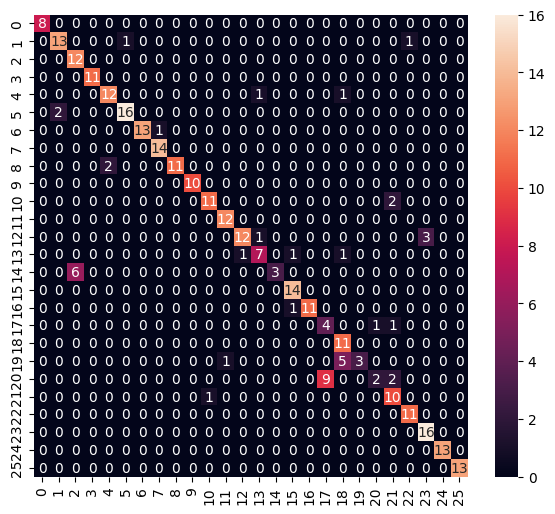

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       0.87      0.87      0.87        15
           2       0.67      1.00      0.80        12
           3       1.00      1.00      1.00        11
           4       0.86      0.86      0.86        14
           5       0.94      0.89      0.91        18
           6       1.00      0.93      0.96        14
           7       0.93      1.00      0.97        14
           8       1.00      0.85      0.92        13
           9       1.00      1.00      1.00        10
          10       0.92      0.85      0.88        13
          11       0.92      1.00      0.96        12
          12       0.92      0.75      0.83        16
          13       0.78      0.70      0.74        10
          14       1.00      0.33      0.50         9
          15       0.88      1.00      0.93        14
          16       1.00      0.92      0.96        12
     

In [90]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [71]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [72]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\KUNALS~1\AppData\Local\Temp\tmpn_cg9n89\assets


INFO:tensorflow:Assets written to: C:\Users\KUNALS~1\AppData\Local\Temp\tmpn_cg9n89\assets


6824

In [73]:
import tensorflowjs as tfjs
tfjs.converters.save_keras_model(model,tfjs_save_path)

# Inference test

In [480]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [481]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [482]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [483]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [484]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.5351619e-01 1.3224893e-10 1.2041709e-09 8.6825191e-10 6.1920882e-06
 1.1019297e-04 1.9010479e-06 4.6348996e-02 1.6548162e-05]
0
